# Droplet spreading over a flat surface against static contact angle $\theta_s$

['/home/asghar/Downloads/wettingTestCases/argoCases/DropletSpreadingTest/test_00000_templateCase/postProcessing/wettedArea.csv', '/home/asghar/Downloads/wettingTestCases/argoCases/DropletSpreadingTest/test_00005_templateCase/postProcessing/wettedArea.csv', '/home/asghar/Downloads/wettingTestCases/argoCases/DropletSpreadingTest/test_00010_templateCase/postProcessing/wettedArea.csv', '/home/asghar/Downloads/wettingTestCases/argoCases/DropletSpreadingTest/test_00015_templateCase/postProcessing/wettedArea.csv']
['/home/asghar/Downloads/wettingTestCases/argoCases/DropletSpreadingTest/test_00000_templateCase/postProcessing/surfaces/', '/home/asghar/Downloads/wettingTestCases/argoCases/DropletSpreadingTest/test_00005_templateCase/postProcessing/surfaces/', '/home/asghar/Downloads/wettingTestCases/argoCases/DropletSpreadingTest/test_00010_templateCase/postProcessing/surfaces/', '/home/asghar/Downloads/wettingTestCases/argoCases/DropletSpreadingTest/test_00015_templateCase/postProcessing/surfac

FileNotFoundError: [Errno 2] No such file or directory: '/home/asghar/Downloads/wettingTestCases/argoCases/DropletSpreadingTest/test_00000_templateCase/postProcessing/wettedArea.csv'

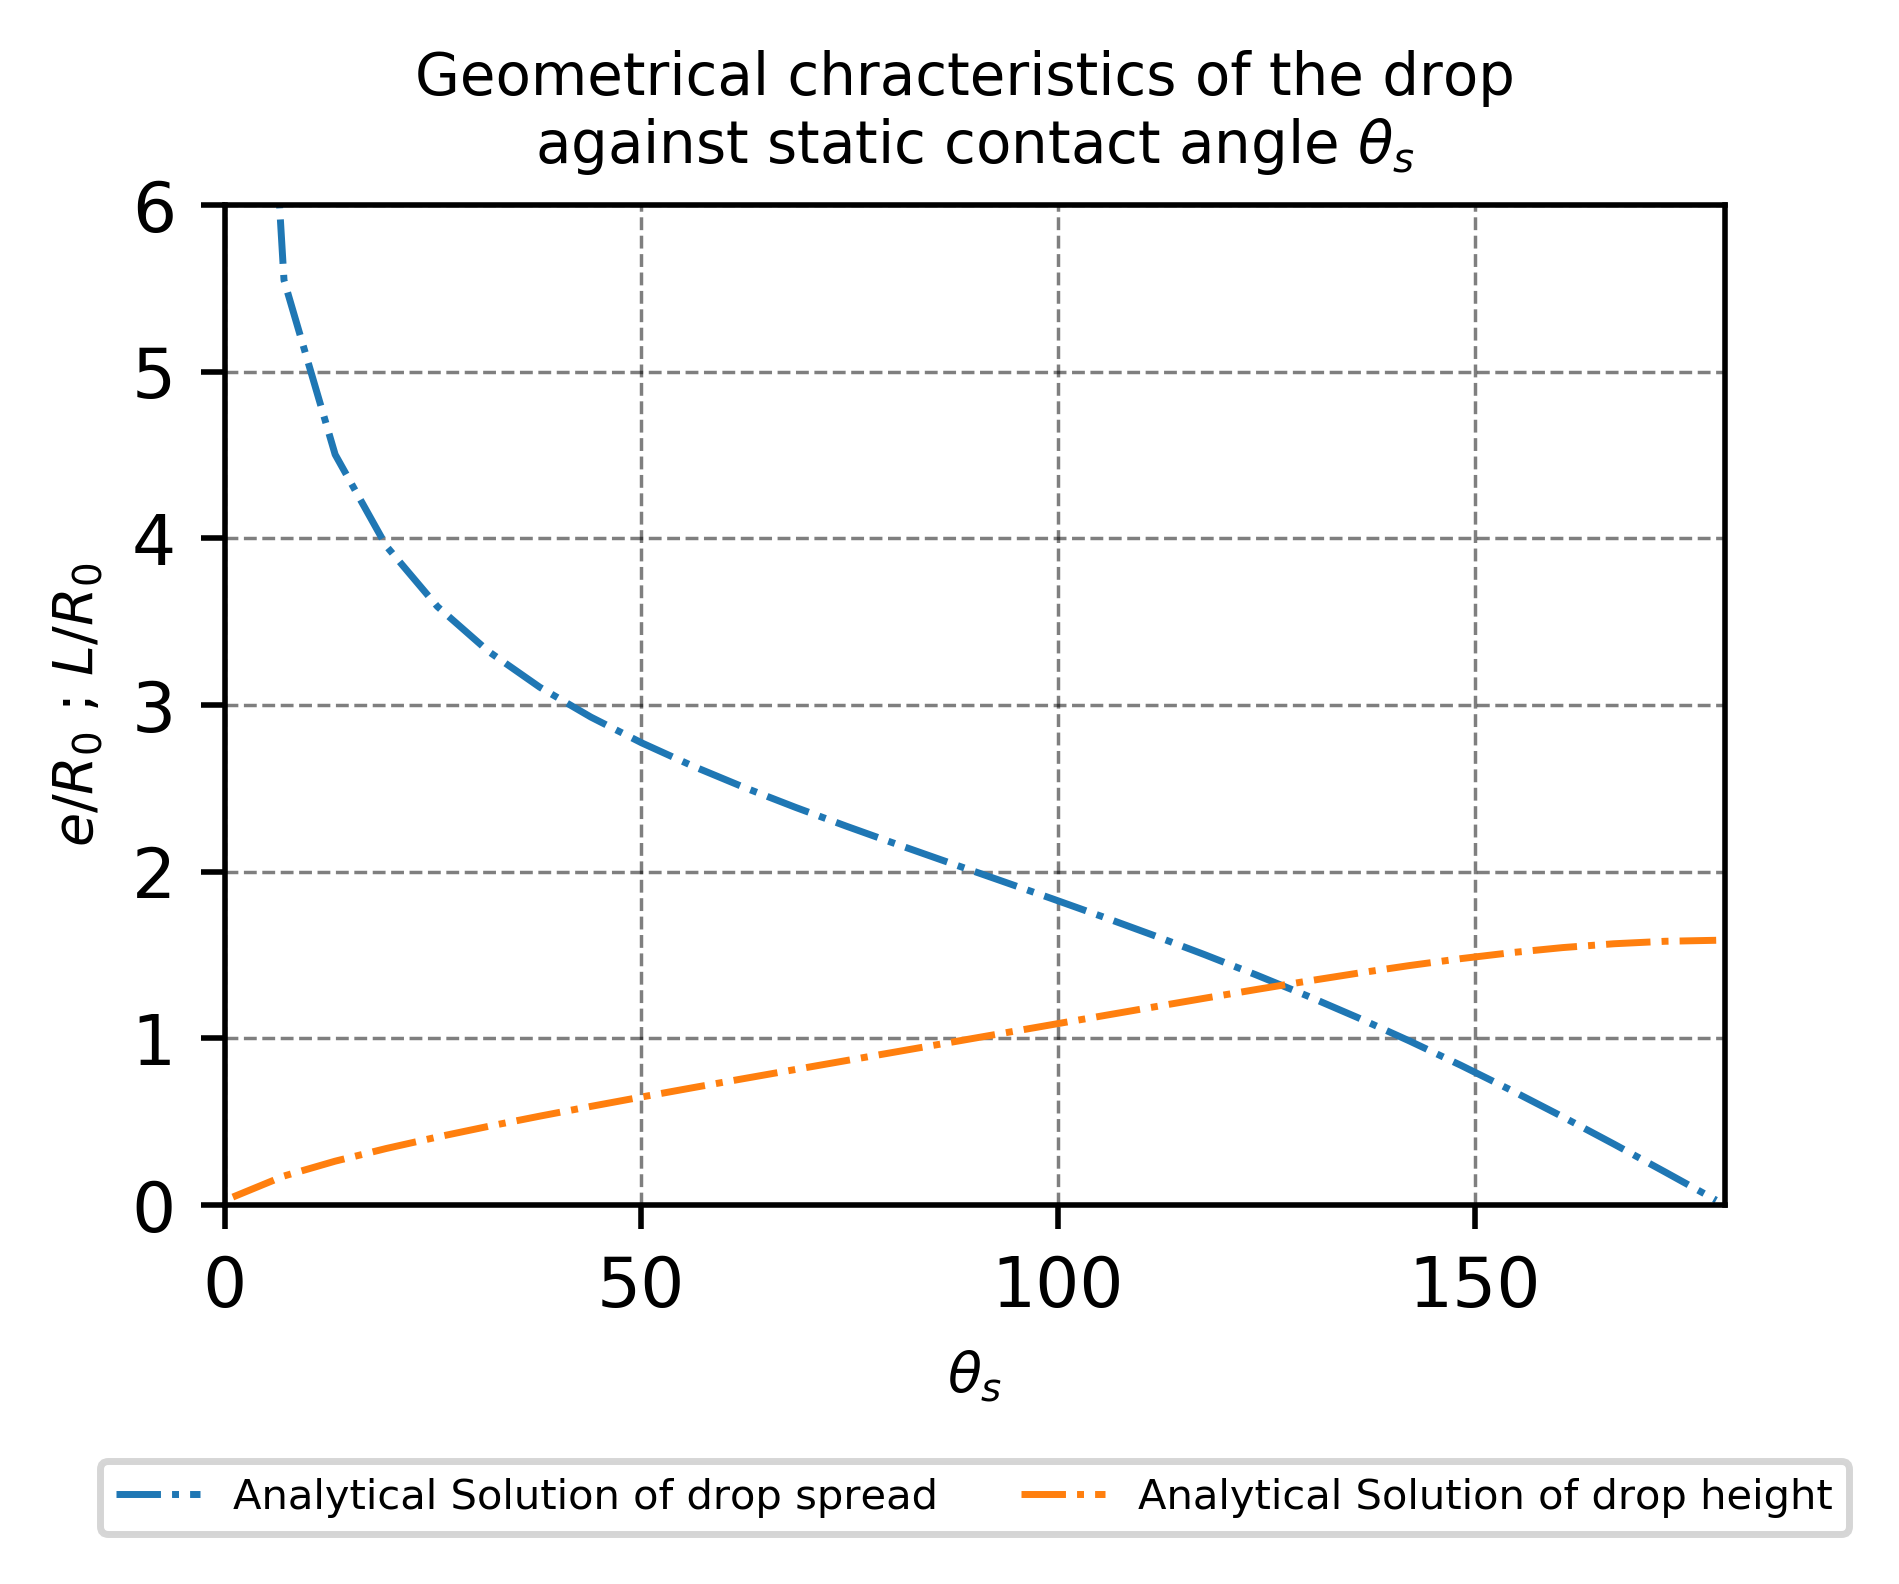

In [3]:
#Loading the necessary files
import pandas as pd
import numpy as np
from vtk import vtkStructuredPointsReader
from vtk.util import numpy_support as VN
import csv
# for radians
import math
import os
import matplotlib.pyplot as plt
import re
import itertools
from matplotlib import rcParams
pi =np.pi
sin = np.sin
cos = np.cos

#######################################################################################

#Geometrical solution implementation/function
def getAnalyticalWettedRadius(contact_angle):
    dropletVolume = 4 / (2*3) * pi * dropletRadius**(3)
    g_theta = sin(theta) * ((pi* ((1-cos(theta))**2) * (2+cos(theta))) / 3)**(-1/3)
    wettedRadius = dropletVolume**(1/3) * g_theta
    wettedArea = pi * wettedRadius**(2)
    r = wettedRadius / sin(theta)
    sphericalCapHeight = r * (1-cos(theta))
    return wettedRadius, sphericalCapHeight

###############################################################################################################

#ZeroGravity Anyalytical Solution
sigma= 0.0635
row_l = 1194.9
SCA_List = np.linspace(1, 179, 30)
dropletRadius = 0.001 #R0

L_List= [None] * 30 ##spread analytical
e_List = [None] * 30 #analytical height

for i, val in enumerate(SCA_List):
    theta = math.radians(SCA_List[i]) 
    L_List[i] = getAnalyticalWettedRadius(theta)[0] *2/dropletRadius #non-dimensional
    e_List[i] = getAnalyticalWettedRadius(theta)[1] /dropletRadius #non-dimensional
    #L_List[i] =  2*dropletRadius*sin(theta)*(pi / (2.0*(theta - (sin(theta)*cos(theta)))))**(1/2)/dropletRadius
    #e_List[i] = dropletRadius*(1-cos(theta))*(pi / (2.0*(theta - (sin(theta)*cos(theta)))))**(1/2) /dropletRadius

###############################################################################################################

#wetted area plot for
fig = plt.figure()
myaxes = fig.add_axes([0.1, 0.1, 0.5, 0.5])

rcParams["figure.dpi"] = 500

plt.plot(SCA_List, L_List, linewidth=1, linestyle='dashdot', label = r"Analytical Solution of drop spread")
plt.plot(SCA_List, e_List, linewidth=1, linestyle='dashdot', label = r"Analytical Solution of drop height")

#     #major grid lines
plt.grid(b=True, which='major', color='black', alpha=0.5, lw=0.5, linestyle='dashed')
plt.title('Geometrical chracteristics of the drop \n' + r'against static contact angle $\theta_s$', fontsize='small')
plt.xlabel(r"$\theta_s$" ,color='black',fontsize=8)
plt.ylabel(r"$e/R_0$ ; $L/R_0$",color='black',fontsize=8)
plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=2)
plt.xlim([0, 180])
plt.ylim([0, 6])

###############################################################################################################
# Height of the droplet at a specific time step Plots
import vtk
#location of vtk files
calcHeights = False

class height_vector:
    x_coord = 0.0
    y_coord = 0.0
    z_coord = 0.0
###############################################################################################################

def fileStructure(dataFile):
    #File structure
    pattern = "test_"
    dataFolder = "/postProcessing/"
    dataFile = dataFile
    cwd = os.getcwd()
    casefolders = [cwd + "/" + folder for folder in os.listdir(cwd) if pattern in folder]    
    datafolders = [df+dataFolder for df in casefolders]
    datafolders.sort()
    fileNames = [fN+dataFile for fN in datafolders]
    return(fileNames)    

################################################################################################################

wettedAreaFileNames = fileStructure('wettedArea.csv')
vtk_folders = fileStructure('surfaces/')
heightFileNames = fileStructure('height.csv')
print(wettedAreaFileNames)
print(vtk_folders)
print(heightFileNames)

plotLabels = ["droplet spread",
              "droplet height"
             ]

#################################################################################################################

#Calculate hieights from the isosurface
if(calcHeights):
    for idx, vtk_folder in enumerate(vtk_folders):
        #getting the time step folder names
        sub_folders = [name for name in os.listdir(vtk_folder) if os.path.isdir(os.path.join(vtk_folder, name))]
        sub_folders.sort()
        numberOfCoordinates = 0.0
        ifCoordArray = 0 # just to take POINTS array
        heightObject = height_vector()
        counter =0

        #file-content
       # header = ['Time(s)', 'Height(m)']
        with open(heightFileNames[idx], 'w') as f:
            writer = csv.writer(f)

        for sub_folder in sub_folders:
            heightObject.z_coord = 0
            with open(vtk_folder + sub_folder +"/isoAlpha.vtk") as reader:
                for line in reader:
                    if "POINTS" in line: #start of coordinates
                        breakUp = line.split()
                        numberOfCoordinates = int(breakUp[1])
                        ifCoordArray = 1;

                    if "\n" not in line[0] and ifCoordArray ==1 and "POINTS" not in line:
                        coordBreakUp = line.split()

                        if (counter ==0):
                            heightObject.z_coord = float (coordBreakUp[2])
                            counter =1
                        else:
                        #check on Z coordinate
                            if (len(coordBreakUp)>3):
                                heightObject.z_coord = max (heightObject.z_coord, float(coordBreakUp[2]))
                                heightObject.z_coord = max (heightObject.z_coord, float(coordBreakUp[5]))
                            else:
                                heightObject.z_coord = max (heightObject.z_coord, float(coordBreakUp[2]))

                    if "\n" in line[0] and ifCoordArray ==1:
                        ifCoordArray =2

            data_to_write_to_csv = [sub_folder, str(heightObject.z_coord)]

            with open(heightFileNames[idx], 'a') as f:
                writer = csv.writer(f)
                writer.writerow(data_to_write_to_csv)

###############################################################################################################
#Plot equilibrium spread against static contact angle

simStaticCAList=[10, 20, 30, 50, 75, 90, 105, 120, 135, 150, 170] #Bond numbers for the simulaitons
equilibriumSpreadList= [None] *len(simStaticCAList)

for idx, wettedFile in enumerate(wettedAreaFileNames):
        with open(wettedAreaFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-1]
            #print(last_line.rsplit(',', 1)[1])
            equilibriumSpreadList[idx] =(2.0*(float(last_line.rsplit(',', 1)[1]) /pi)**(1/2) / dropletRadius)

plt.plot(simStaticCAList, equilibriumSpreadList,
            marker='s',
            markerfacecolor='None',
            linestyle = 'None', label=plotLabels[0])

###############################################################################################################
#Plot equilibrium height against static contact angle

equilibriumHeightList= [None] *len(simStaticCAList)

for idx, heightFile in enumerate(heightFileNames):
        with open(heightFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-1]
            #print(last_line)
            equilibriumHeightList[idx] =(float(last_line.rsplit(',', 1)[1]) / dropletRadius)

plt.plot(simStaticCAList, equilibriumHeightList,
            marker='s',
            markerfacecolor='None',
            linestyle = 'None', label=plotLabels[1])
### Generate the plot

plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.5, -.4), ncol=2)
plt.savefig('droplet-chractersitics-against-static-contact-angle'+'.png', bbox_inches='tight')
#plt.savefig('Normalized droplet height'+'.png', bbox_inches='tight')
plt.show()

# Droplet Spreading over a flat surface against Bond number, Bo

wetted radius 0.0008221733120513639
spherical0.0011741851768027175


FileNotFoundError: [Errno 2] No such file or directory: '/home/asghar/Downloads/wettingTestCases/argoCases/DropletSpreadingTest/wgtest_00000_templateCase/postProcessing/height.csv'

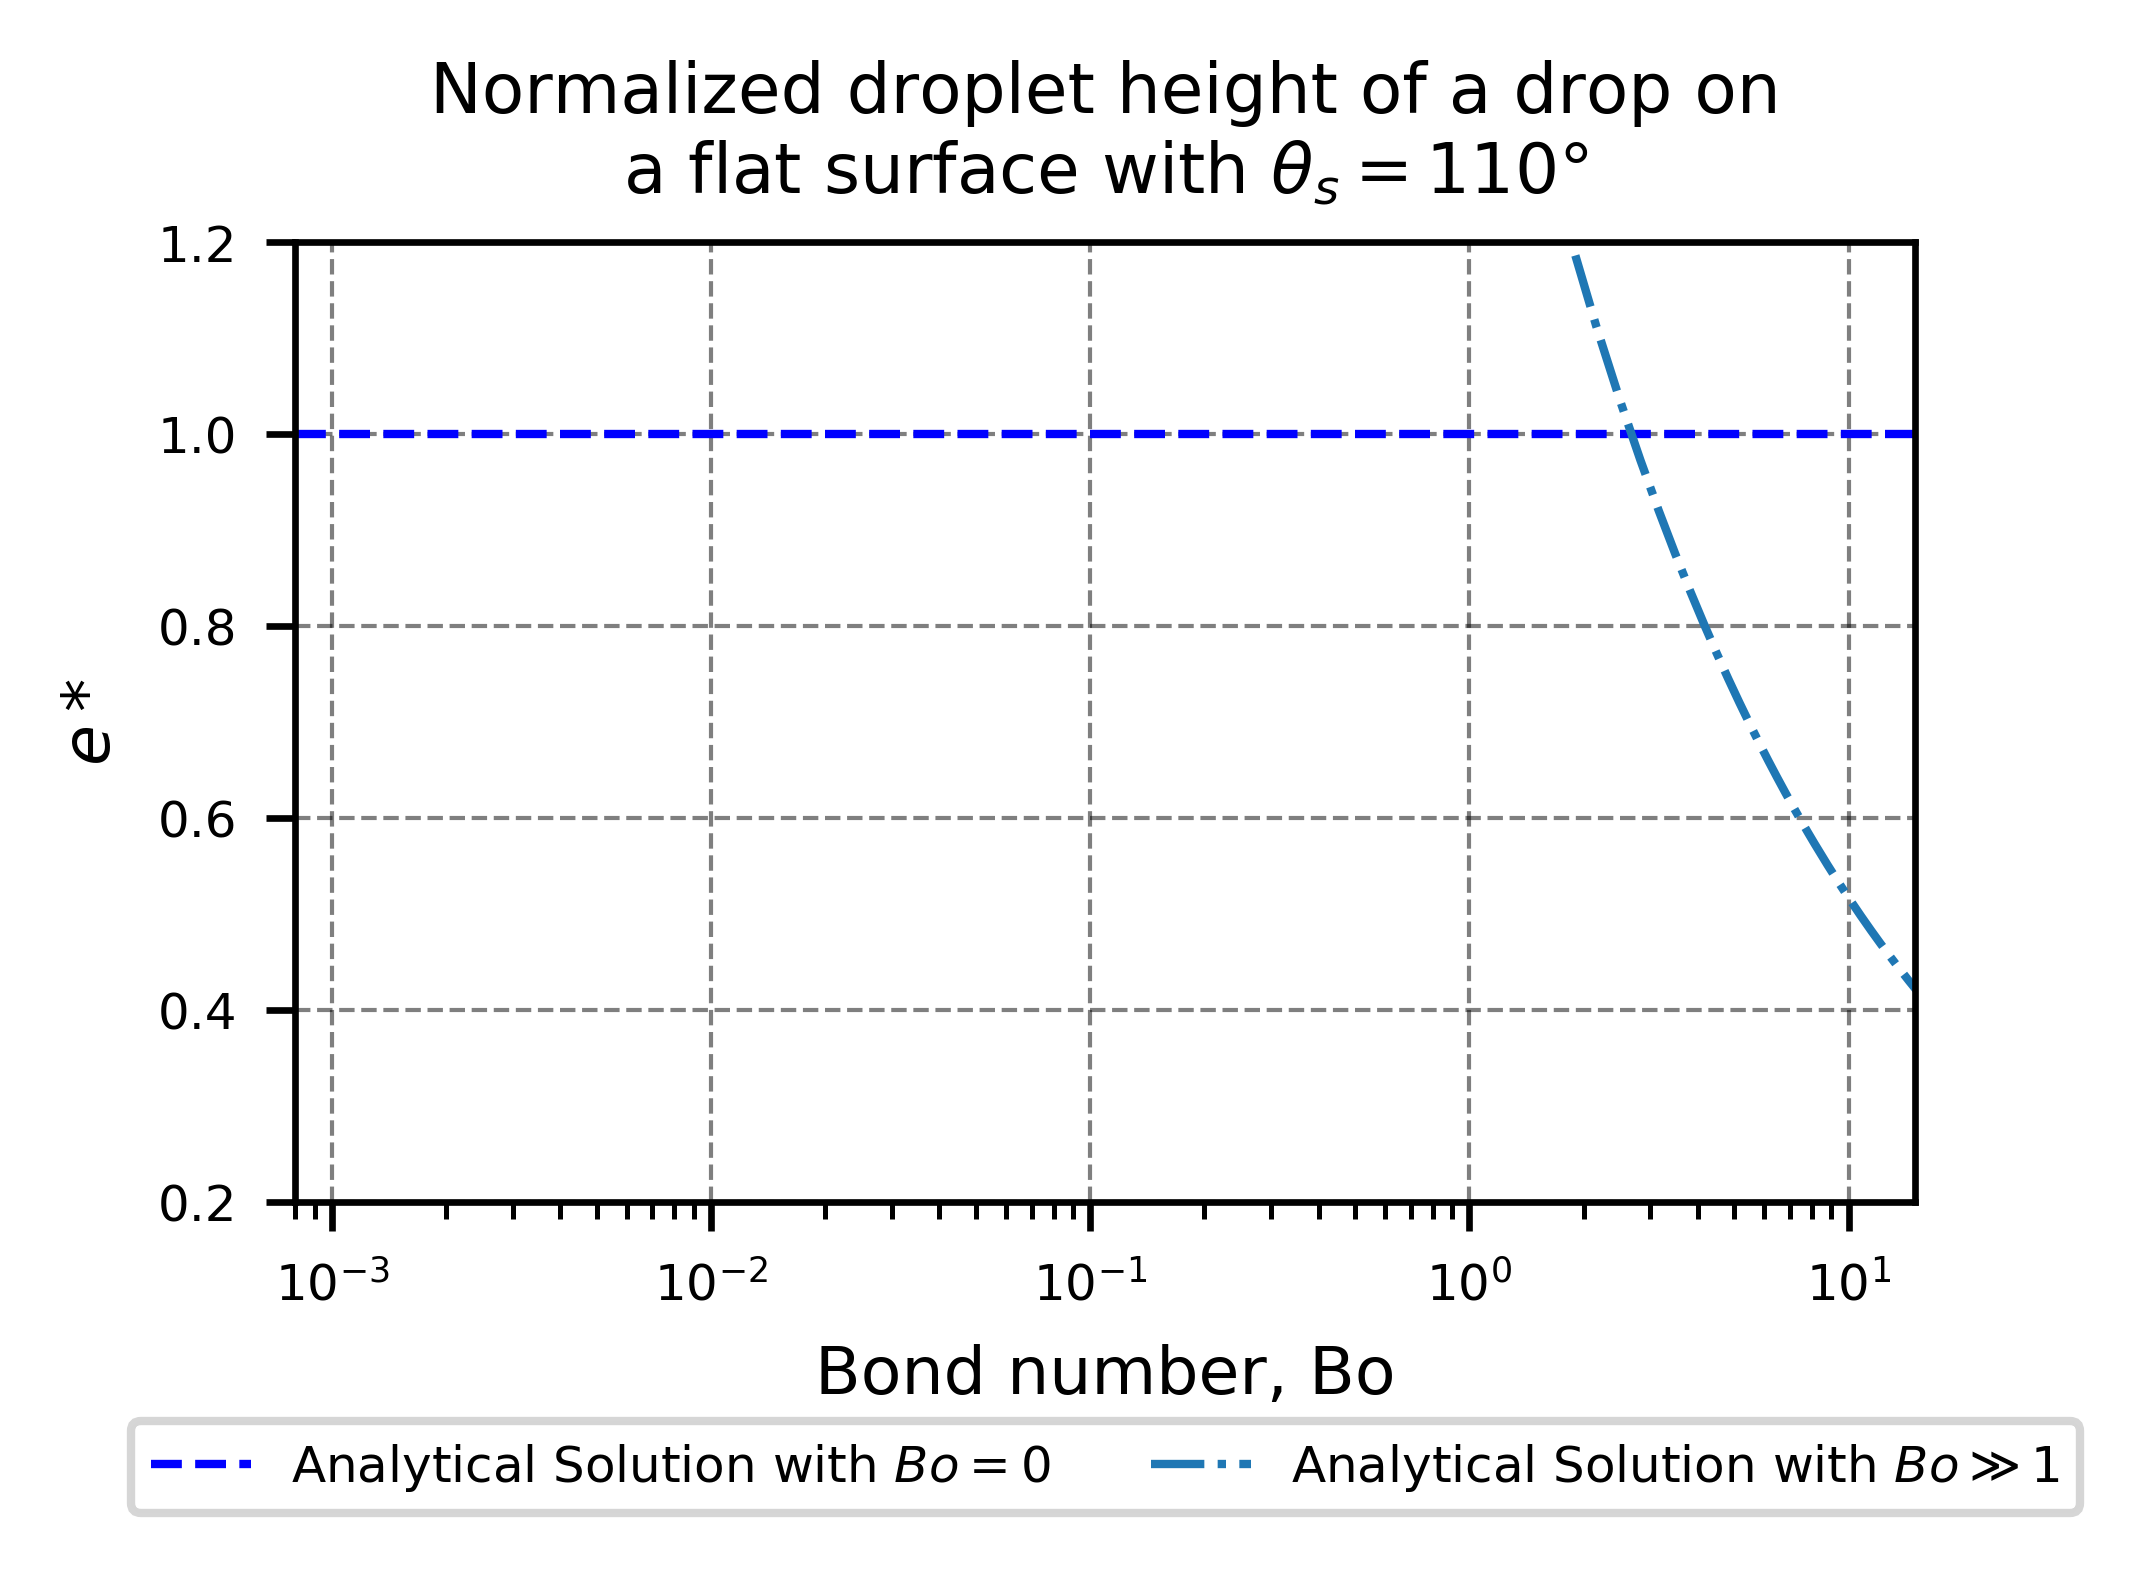

In [7]:
#Loading the necessary files
import pandas as pd
import numpy as np
from vtk import vtkStructuredPointsReader
from vtk.util import numpy_support as VN
import csv
# for radians
import math
import os
import matplotlib.pyplot as plt
import re
import itertools
from matplotlib import rcParams

pi =np.pi
sin = np.sin
cos = np.cos

#######################################################################################
#Geometrical solution implementation/function
# def getAnalyticalWettedArea(contact_angle):
#     theta = math.radians(contact_angle) #static angle theta_s
#     g_theta = sin(theta) * ((pi* ((1-cos(theta))**2) * (2+cos(theta))) / 3)**(-1/3)
#     wettedRadius = dropletVolume**(1/3) * g_theta
#     wettedArea = pi * wettedRadius**(2)
#     return wettedArea

#######################################################################################

#Geometrical solution implementation/function
def getAnalyticalWettedRadius(theta):
    dropletVolume = 4 / (2*3) * pi * dropletRadius**(3)
    g_theta = sin(theta) * ((pi* ((1-cos(theta))**2) * (2+cos(theta))) / 3)**(-1/3)
    wettedRadius = dropletVolume**(1/3) * g_theta
    print( "wetted radius " + str(wettedRadius))
    wettedArea = pi * wettedRadius**(2)
    r = wettedRadius / sin(theta)
    sphericalCapHeight = r * (1-cos(theta))
    print("spherical" +str(sphericalCapHeight))
    return wettedRadius, sphericalCapHeight

#######################################################################################
#ZeroGravity Anyalytical Solution
sigma= 0.0635
row_l = 1194.9
Bo_List = np.linspace(0.5, 50, 150)
dropletRadius = 0.001 #R0
dropletVolume = 4 / (2*3) * pi * dropletRadius**(3)
contact_angle = 50
theta = math.radians(contact_angle) #static angle theta_s

e_0 = getAnalyticalWettedRadius(theta)[1]

#For Eo(Bo) >> 1, the droplet height is,
def eInf(g):
    return 2*(sigma/row_l/g)**(1/2) * (theta/2)

eInf_list = [None] * 150

for i, val in enumerate(Bo_List):
    g = Bo_List[i] * sigma / row_l /dropletRadius**(2)
    eInf_list[i] = eInf(g) / e_0

#######################################################################################

#wetted area plot for 
fig = plt.figure()
myaxes = fig.add_axes([0.1, 0.1, 0.45, 0.4])
rcParams["figure.dpi"] = 600

#Reference solution line
plt.axhline(e_0/e_0, color='blue' , linestyle='dashed', linewidth=1, label = r"Analytical Solution with $Bo=0$")
plt.plot(Bo_List, eInf_list, linewidth=1, linestyle='dashdot', label = r"Analytical Solution with $Bo\gg1$")
   
##major grid lines
plt.grid(b=True, which='major', color='black', alpha=0.5, lw=0.5, linestyle='dashed')
plt.title('Normalized droplet height of a drop on\n' + r'a flat surface with $\theta_s = 110°$', fontsize='small')
plt.xlabel(r"Bond number, Bo" ,color='black',fontsize=8)
plt.ylabel(r"$e*$",color='black',fontsize=8)
plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=2)      
plt.xlim([0.0008, 15])
plt.ylim([0.2, 1.2])
plt.xscale('log')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

###############################################################################################################

# Height of the droplet at a specific time step Plots
import vtk
#location of vtk files

class height_vector:
    x_coord = 0.0
    y_coord = 0.0
    z_coord = 0.0
    
###############################################################################################################

def fileStructure(dataFile, fluid):   
    #File structure    
    pattern = fluid + "test_"
    dataFolder = "/postProcessing/"
    dataFile = dataFile
    cwd = os.getcwd()
    casefolders = [cwd + "/" + folder for folder in os.listdir(cwd) if pattern in folder]    
    datafolders = [df+dataFolder for df in casefolders]
    datafolders.sort()
    fileNames = [fN+dataFile for fN in datafolders]
    return(fileNames)    

###############################################################################################################

#location of vtk files
def writeHeightFile(calcHeights):
    if(calcHeights):
        for idx, vtk_folder in enumerate(vtk_folders):
            #getting the time step folder names
            sub_folders = [name for name in os.listdir(vtk_folder) if os.path.isdir(os.path.join(vtk_folder, name))]
            sub_folders = sorted(sub_folders, key=float)

            #file-content
           # header = ['Time(s)', 'Height(m)']
            with open(heightFileNames[idx], 'w') as f:
                writer = csv.writer(f)

            for sub_folder in sub_folders:
                heightObject = height_vector()
                heightObject.z_coord = 0
                #ifCoordArray = 0
                numberOfCoordinates = 0.0
                ifCoordArray = 0 # just to take POINTS array
                counter =0
                with open(vtk_folder + sub_folder +"/isoAlpha.vtk") as reader:
                    for line in reader:
                        if "POINTS" in line: #start of coordinates
                            breakUp = line.split()
                            numberOfCoordinates = int(breakUp[1])
                            ifCoordArray = 1;

                        elif "\n" not in line[0] and ifCoordArray ==1 and "POINTS" not in line:
                            coordBreakUp = line.split()
                            #print(coordBreakUp)
                            coordPerLine = int(len(coordBreakUp) / 3)
                            
                            if (counter ==0):
                                heightObject.z_coord = float (coordBreakUp[2])
                                counter =1
                            if(counter==1):
                            #check on Z coordinate
                                for i in range(0, coordPerLine):
                                    coordinateIndex = ((int(len(coordBreakUp)-1)%3)) + (i*3)
                                    heightObject.z_coord = max (heightObject.z_coord, float(coordBreakUp[coordinateIndex]))

                        if "\n" in line[0] and ifCoordArray ==1:
                            ifCoordArray =2

                data_to_write_to_csv = [sub_folder, str(heightObject.z_coord)]
                
                with open(heightFileNames[idx], 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow(data_to_write_to_csv)
                    
##############################################################################################################
    
#WATER_GLLYCEROL
wettedAreaFileNames = fileStructure('wettedArea.csv', 'wg')
vtk_folders = fileStructure('surfaces/', 'wg')
heightFileNames = fileStructure('height.csv', 'wg')
#print(heightFileNames)
#print(wettedAreaFileNames)
#print(vtk_folders)
calcHeights = False
writeHeightFile(calcHeights)
plotLabels = [
              "water_glycerol droplet height"
             ]

# #Plot equilibrium height against Eo number - water-glycerol
equilibriumHeightList= [None] *7 
simBoList=[0.001, 0.01, 0.1,  0.5, 1, 5, 10] #Bond numbers for the simulaitons
theta = math.radians(contact_angle)

nPointsForHeightAverage = 20
for idx, heightFile in enumerate(heightFileNames):
    avgHeight = 0
    for i in range(1, nPointsForHeightAverage):
        with open(heightFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-i]
            avgHeight += float(last_line.rsplit(',', 1)[1])
    avgHeight /= (nPointsForHeightAverage-1)
    equilibriumHeightList[idx] = (avgHeight /e_0 ) 
print(equilibriumHeightList)       
plt.plot(simBoList, equilibriumHeightList,  
            marker='o', markerfacecolor='None',
            linestyle = 'None', label="simulation results - water_glycerol")

###############################################################################################################

#WATER
wettedAreaFileNames = fileStructure('wettedArea.csv', 'w')
vtk_folders = fileStructure('surfaces/', 'w')
heightFileNames = fileStructure('height.csv', 'w')
print(heightFileNames)
print(wettedAreaFileNames)
print(vtk_folders)
calcHeights = False
writeHeightFile(calcHeights)
plotLabels = [
              "water droplet height"
             ]

#Plot equilibrium height against Eo number - water
equilibriumHeightList= [None] *7 
simBoList=[0.001, 0.01, 0.1,  0.5, 1, 5, 10] #Bond numbers for the simulaitons
theta = math.radians(contact_angle)

nPointsForHeightAverage = 20
for idx, heightFile in enumerate(heightFileNames):
    avgHeight = 0
    for i in range(1, nPointsForHeightAverage):
        with open(heightFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-i]
            avgHeight += float(last_line.rsplit(',', 1)[1])
    avgHeight /= (nPointsForHeightAverage-1)
    equilibriumHeightList[idx] = (avgHeight /e_0 ) 
    
plt.plot(simBoList, equilibriumHeightList,  
            marker='s', markerfacecolor='None', c = 'brown',
            linestyle = 'None', label="simulation results - water")

plt.legend(fontsize=5.5, loc='lower center', bbox_to_anchor=(0.3, 0), ncol=1)
# ### Generate the plot
# plt.savefig('Normalized droplet height'+'.pdf', bbox_inches='tight')
#plt.savefig('Normalized-droplet-height-plot-against-Bo-110'+'.png', bbox_inches='tight')
plt.show()